In [1]:
import os
csv_files = [file for file in os.listdir('preds') if file.endswith('.csv')]
csv_files.sort()
len(csv_files)
preds_5 = []
for seed in range(100):
    filtered = [file for file in csv_files if file.startswith(f'rus_5_{seed}')]
    preds_5.append((filtered[-1], filtered[-2]))

In [2]:
preds_10 = []
for seed in range(18):
    filtered = [file for file in csv_files if file.startswith(f'rus_10_{seed}')]
    preds_10.append((filtered[-1], filtered[-2]))

In [3]:
import pandas as pd
def aggregate_pred_dataframe(files):
    dfs = [pd.read_csv(f) for f in files]
    final_df = dfs[0].rename(columns={'pred': 'pred_0'})
    for i in range(1, len(dfs)):
        final_df[f'pred_{i}'] = dfs[i]['pred']
    return final_df.reset_index()

df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in preds_5][:50] + [f'preds/{i[0]}' for i in preds_10][:0])
df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in preds_5][:50] + [f'preds/{i[1]}' for i in preds_10][:0])
df_valid

,index,protein_index,residue_index,target,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,...,pred_40,pred_41,pred_42,pred_43,pred_44,pred_45,pred_46,pred_47,pred_48,pred_49
0,0,0,0,0,-8.98775,-15.11055,-13.98213,-11.29869,-16.61864,-12.49924,...,-15.00598,-14.03294,-18.28101,-10.64688,-14.82197,-8.22801,-10.83991,-13.67239,-14.07019,-15.84578
1,1,0,1,0,-9.46738,-15.24818,-13.14582,-14.53493,-15.32660,-15.24240,...,-14.33248,-8.08441,-18.75846,-10.77215,-20.69430,-10.91299,-12.55298,-14.11223,-17.77555,-11.44264
2,2,0,2,0,-10.12774,-9.69807,-12.96733,-11.69899,-13.53942,-13.42710,...,-6.90897,-8.43097,-18.67209,-6.73092,-19.38489,-3.70953,-8.24672,-9.23847,-12.77485,-7.89918
3,3,0,3,0,-13.16287,-14.17841,-14.32559,-14.32278,-15.20325,-18.69769,...,-11.05568,-12.67103,-19.29591,-13.91463,-21.04154,-10.36948,-12.22527,-13.89337,-22.34781,-13.36948
4,4,0,4,0,-15.14742,-18.90797,-15.98578,-17.98466,-15.64044,-17.01869,...,-13.81927,-11.10007,-17.64072,-14.36389,-21.55991,-11.11141,-14.10533,-16.64345,-19.12222,-15.54502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21515,21515,75,185,0,-17.66712,-18.78570,-14.87798,-15.09693,-10.95780,-17.41352,...,-20.07335,-15.49787,-15.45490,-14.75026,-16.45495,-12.41315,-11.78074,-9.73223,-18.94955,-12.39304
21516,21516,75,186,0,-18.84964,-19.06868,-18.70679,-17.16606,-15.14629,-21.23797,...,-18.73736,-13.55984,-16.24479,-16.50637,-19.48132,-21.62120,-16.89460,-12.81877,-22.48002,-17.24781
21517,21517,75,187,0,-9.89198,-8.94944,-7.27119,-10.88630,-7.13525,-10.88348,...,-13.29691,-7.33957,-11.89487,-5.91391,-14.46903,-8.06874,-4.26674,-6.11689,-12.81917,-6.58958
21518,21518,75,188,0,-14.91735,-18.15037,-13.21254,-14.30542,-10.35410,-17.90483,...,-16.30089,-13.83095,-21.18325,-12.95685,-19.31005,-11.33649,-8.97969,-10.26018,-18.57287,-13.14248


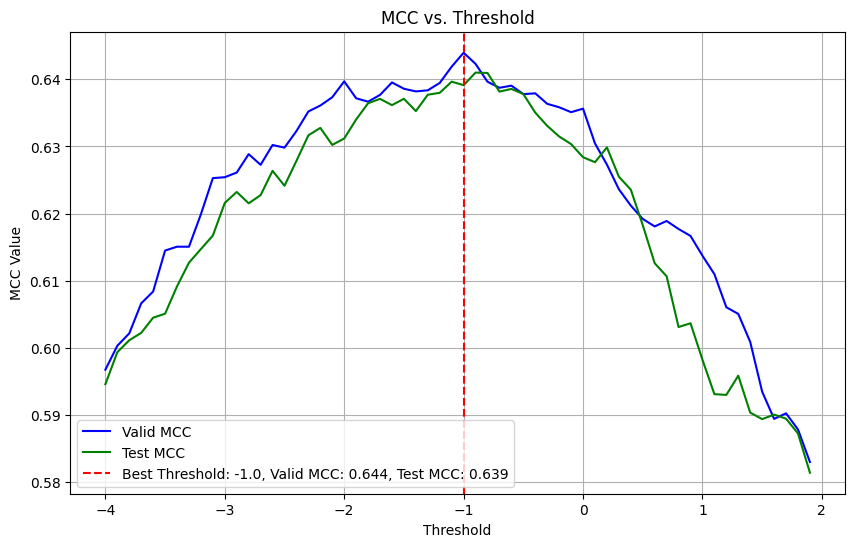

{'best_threshold': -1.0,
 'valid_mcc': 0.6439,
 'sensitivity': 0.5646,
 'specificity': 0.9902,
 'accuracy': 0.9682,
 'precision': 0.7597,
 'mcc': 0.6391}

In [7]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np

def round_dict(d, n):
    return {k: round(v, n) if isinstance(v, float) else v
                for k, v in d.items()}

def generate_mean_ensemble_metrics(df, threshold=0):
    sum_preds = df[list(filter(lambda a: a.startswith('pred_'), df.columns.tolist()))].mean(axis=1)
    final_prediction = (sum_preds > threshold).astype(int)

    # Sensitivity (Recall)
    sensitivity = recall_score(df['target'], final_prediction)

    # Specificity
    tn, fp, fn, tp = confusion_matrix(df['target'], final_prediction).ravel()
    specificity = tn / (tn + fp)

    # Accuracy
    accuracy = accuracy_score(df['target'], final_prediction)

    # Precision
    precision = precision_score(df['target'], final_prediction)
    mcc = matthews_corrcoef(df['target'], final_prediction)
    return {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "accuracy": accuracy,
        "precision": precision,
        "mcc": mcc,
    }
    
def draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=0, end=30, plot=True):
    # Create a list of thresholds to test
    thresholds = np.arange(start, end, 0.1)  # Adjust the step size as necessary
    valid_mccs = []
    test_metrics = []

    # Loop through thresholds and compute MCC
    for threshold in thresholds:
        metrics = generate_mean_ensemble_metrics(df_valid, threshold)
        valid_mccs.append(metrics['mcc'])
        
        metrics_test = generate_mean_ensemble_metrics(df_test, threshold)
        test_metrics.append(metrics_test)

    # Identify threshold with the best MCC
    best_threshold_arg = np.argmax(valid_mccs)
    best_threshold = thresholds[best_threshold_arg]

    label = f'Best Threshold: {best_threshold:.1f}, Valid MCC: {valid_mccs[best_threshold_arg]:.3f}, Test MCC: {test_metrics[best_threshold_arg]["mcc"]:.3f}'
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, valid_mccs, label='Valid MCC', color='blue')
        plt.plot(thresholds, [i['mcc'] for i in test_metrics], label='Test MCC', color='green')
        plt.axvline(x=best_threshold, color='red', linestyle='--', label=label)
        plt.xlabel('Threshold')
        plt.ylabel('MCC Value')
        plt.title('MCC vs. Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    return {
        'best_threshold': best_threshold, 
        'valid_mcc': valid_mccs[best_threshold_arg],
        **test_metrics[best_threshold_arg]
    }

    
round_dict(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-4, end=2), 4)


In [9]:
# try n = 50 ensemble 10 times
from random import sample
df = pd.DataFrame()
for i in range(10):
    sample_preds = sample(preds_5, 50)
    df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in sample_preds])
    df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in sample_preds])
    new_row = [draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-3, end=1, plot=False)]
    new_df = pd.DataFrame(new_row)
    df = pd.concat([df, new_df], ignore_index=True)


In [12]:
df.aggregate(['mean', 'std']).T

,mean,std
best_threshold,-1.280000,0.396653
valid_mcc,0.643483,0.001603
sensitivity,0.580223,0.009109
specificity,0.988518,0.000866
accuracy,0.967372,0.000410
precision,0.734385,0.011849
mcc,0.636162,0.002386


In [10]:
mccs = []
from random import sample
df = pd.DataFrame()
for sz in range(1, 21):
    for i in range(10):
        sample_preds = sample(preds_5, sz)
        df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in sample_preds])
        df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in sample_preds])
        mccs.append(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-4, end=2, plot=False)[2])
        new_rows = [{
            'size': sz,
            'mcc': mccs[-1]['mcc']
        }]
        new_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_df], ignore_index=True)
    print(f'{sz} done')


1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done


<Axes: xlabel='size'>

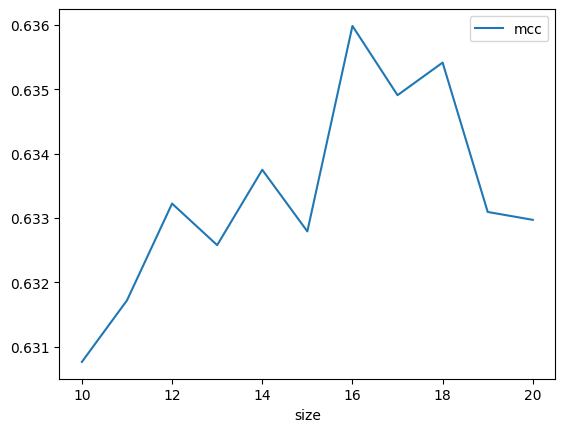

In [12]:
df[df['size'] >= 10].groupby('size').mean().plot()

In [13]:
for sz in range(21, 30):
    for i in range(10):
        sample_preds = sample(preds_5, sz)
        df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in sample_preds])
        df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in sample_preds])
        mccs.append(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-4, end=2, plot=False)[2])
        new_rows = [{
            'size': sz,
            'mcc': mccs[-1]
        }]
        new_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_df], ignore_index=True)
    print(f'{sz} done')

21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done


<Axes: xlabel='size'>

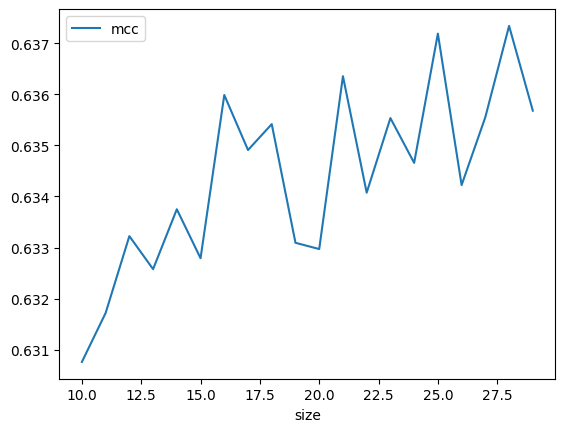

In [14]:
df[df['size'] >= 10].groupby('size').mean().plot()

In [15]:
for sz in range(30, 51):
    for i in range(10):
        sample_preds = sample(preds_5, sz)
        df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in sample_preds])
        df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in sample_preds])
        mccs.append(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-4, end=2, plot=False)[2])
        new_rows = [{
            'size': sz,
            'mcc': mccs[-1]
        }]
        new_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_df], ignore_index=True)
    print(f'{sz} done')

30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done


<Axes: xlabel='size'>

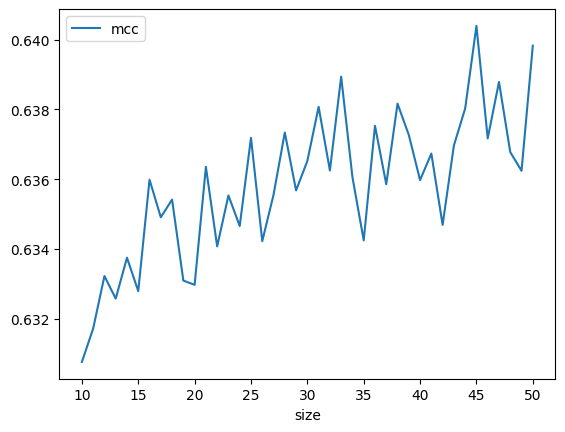

In [16]:
df[df['size'] >= 10].groupby('size').mean().plot()

In [18]:
for sz in range(51, 60):
    for i in range(10):
        sample_preds = sample(preds_5, sz)
        df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in sample_preds])
        df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in sample_preds])
        mccs.append(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-4, end=2, plot=False)[2])
        new_rows = [{
            'size': sz,
            'mcc': mccs[-1]
        }]
        new_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_df], ignore_index=True)
    print(f'{sz} done')

51 done
52 done
53 done
54 done
55 done
56 done
57 done
58 done
59 done


<Axes: xlabel='size'>

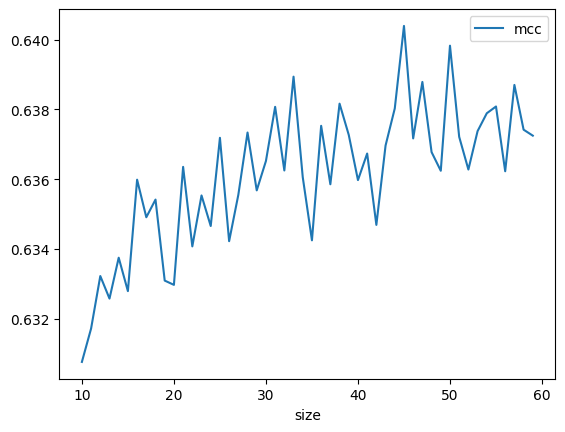

In [19]:
df[df['size'] >= 10].groupby('size').mean().plot()

In [20]:
for sz in range(10, 60):
    for i in range(10):
        sample_preds = sample(preds_5, sz)
        df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in sample_preds])
        df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in sample_preds])
        mccs.append(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-4, end=2, plot=False)[2])
        new_rows = [{
            'size': sz,
            'mcc': mccs[-1]
        }]
        new_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_df], ignore_index=True)
    print(f'{sz} done')

10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
